In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import os

In [3]:
from scipy.stats import multivariate_normal

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
class Obj:
    pass

In [6]:
params = Obj()
params.input_dim = 784 
params.n_labels = 10 
params.hidden_encoder_dim = 400
params.hidden_decoder_dim = 400
params.latent_dim = 15
params.lam = 0

In [7]:
def weight_variable(shape, stddev = .1):
    xav_stddev = stddev * np.sqrt( 1. / shape[0])
    initial = tf.random_normal(shape = shape, stddev = xav_stddev)
    return tf.Variable(initial)

In [8]:
x = tf.placeholder(dtype=tf.float32, shape=[None, params.input_dim])
y = tf.placeholder(dtype=tf.float32, shape=[None, params.n_labels])
l2_loss = tf.constant(0.0)

In [9]:
# Hidden layer encoder
W_encoder_input_hidden = weight_variable([params.input_dim, params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)
hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden)) 

In [10]:
# Hidden y layer encoder
W_encoder_y_hidden = weight_variable([params.n_labels, params.hidden_encoder_dim])
l2_loss += tf.nn.l2_loss(W_encoder_y_hidden)
hidden_y_encoder = tf.nn.leaky_relu(tf.matmul(y, W_encoder_y_hidden)) 

In [11]:
# Mu encoder
W_encoder_hidden_mu = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)

In [12]:
# Mu y encoder
W_encoder_hidden_y_mu = weight_variable([params.hidden_encoder_dim, params.latent_dim])
#W_encoder_hidden_y_mu = weight_variable([params.n_labels, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_y_mu)

In [13]:
mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + tf.matmul(hidden_y_encoder, W_encoder_hidden_y_mu)
#mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + tf.matmul(y, W_encoder_hidden_y_mu)

In [14]:
# Sigma encoder
W_encoder_hidden_logvar = weight_variable([params.hidden_encoder_dim, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)

In [15]:
# Sigma y encoder
#W_encoder_hidden_y_logvar = weight_variable([params.hidden_encoder_dim, params.latent_dim])
W_encoder_hidden_y_logvar = weight_variable([params.n_labels, params.latent_dim])
l2_loss += tf.nn.l2_loss(W_encoder_hidden_y_logvar)

In [16]:
#logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + tf.matmul(hidden_y_encoder, W_encoder_hidden_y_logvar)
logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + tf.matmul(y, W_encoder_hidden_y_logvar)

In [17]:
# Sample epsilon
epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
# Sample latent variable
std_encoder = tf.exp(0.5 * logvar_encoder)
z = mu_encoder + tf.multiply(std_encoder, epsilon)

In [18]:
# Hidden y reconstruction layer
W_decoder_z_y_hidden = weight_variable([params.latent_dim, params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(W_decoder_z_y_hidden)
hidden_y_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_y_hidden))

In [19]:
# y reconstruction layer 
W_decoder_y_reconstruction = weight_variable([params.hidden_decoder_dim, params.n_labels])
l2_loss += tf.nn.l2_loss(W_decoder_y_reconstruction)
y_hat_logit = tf.matmul(hidden_y_decoder, W_decoder_y_reconstruction)

In [20]:
# Hidden layer decoder
W_decoder_z_hidden = weight_variable([params.latent_dim, params.hidden_decoder_dim])
l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)
hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden))

In [21]:
# Reconstruction layer 
W_decoder_hidden_reconstruction = weight_variable([params.hidden_decoder_dim, params.input_dim])
l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)
x_hat_logit = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) 

## Loss

In [86]:
# Loss
# KL Divergence (Log Gaussian)
KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)) #, reduction_indices=1)
#KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder)) #, reduction_indices=1)
# Reconstruction Loss
BCE_x = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat_logit, labels=x))#, reduction_indices=1)
#BCE_x = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat_logit, labels=x)) #, reduction_indices=1)
BCE_y = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat_logit, labels=y))#, reduction_indices=1)
#BCE_y = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat_logit, labels=y)) #, reduction_indices=1)
loss = tf.reduce_mean(BCE_x + BCE_y + KLD)
loss_x = tf.reduce_mean(BCE_x + KLD) # ZERO_Y (x predit x)
loss_y = tf.reduce_mean(BCE_y + KLD) # ZERO_X (y predit y)
regularized_loss = loss + params.lam * l2_loss

## Train

In [87]:
# Train
loss_summ = tf.summary.scalar("lowerbound", loss)
train_step = tf.train.AdamOptimizer(0.01).minimize(regularized_loss)
# add op for merging summary
summary_op = tf.summary.merge_all()

In [88]:
## 

In [89]:
# add Saver ops
saver = tf.train.Saver()

In [90]:
n_steps = int(1e6)
batch_size = 100

In [91]:
sess = tf.InteractiveSession()

In [101]:
summary_writer = tf.summary.FileWriter('experiment',
                                      graph=sess.graph)
if os.path.isfile("save/model.ckpt"):
    print("Restoring saved parameters")
    saver.restore(sess, "save/model.ckpt")
else:
    print("Initializing parameters")
    sess.run(tf.global_variables_initializer())

for step in range(1, n_steps):
    batch = mnist.train.next_batch(batch_size)
    if step % 10 == 9:
        feed_dict = {x: batch[0], y:batch[1]}
        _, cur_loss, summary_str = sess.run([train_step, loss, summary_op], feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
    else : #if step % 3 == 1:
        # x predit x
        feed_dict = {x: batch[0], y:batch[1] * 0}
        _, cur_loss, summary_str = sess.run([train_step, loss_x, summary_op], feed_dict=feed_dict)
    #else:
        # y predit y
    #    feed_dict = {x: batch[0] * 0, y:batch[1]}
    #    _, cur_loss, summary_str = sess.run([train_step, loss_y, summary_op], feed_dict=feed_dict)
    if step % 50 == 0:
        save_path = saver.save(sess, "save/model.ckpt")
        sys.stdout.write("\rStep {0} | Loss: {1}".format(step, cur_loss))


Initializing parameters
Step 31500 | Loss: 11485.8632812555

KeyboardInterrupt: 

In [102]:
batch = mnist.train.next_batch(batch_size)
liste_z = z.eval(feed_dict={x: batch[0], y:batch[1]})

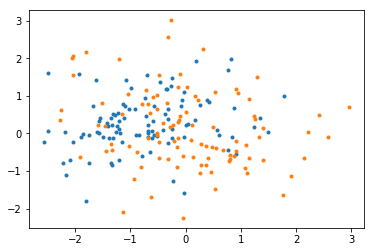

In [103]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
ref = np.random.randn(batch_size, params.latent_dim)
plt.plot(ref[:,0], ref[:,1], '.')

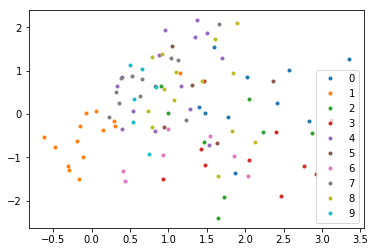

In [149]:
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(batch[1][i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[4,:], z_aff[3,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))

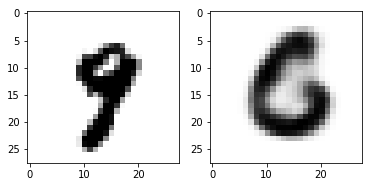

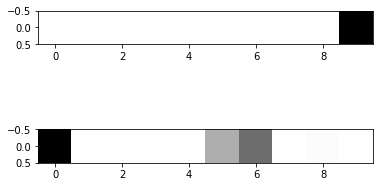

In [131]:
TEST_ZERO_x = 0
TEST_ZERO_y = 1
x_hat_logit_test, y_hat_logit_test = sess.run((x_hat_logit, y_hat_logit), feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
x_hat = sess.run(tf.nn.sigmoid(x_hat_logit_test))
y_hat = sess.run(tf.nn.sigmoid(y_hat_logit_test))

i = 1
plt.subplot(1,2,1)
plt.imshow(batch[0][i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_hat[i].reshape((28, 28)), cmap = 'gray_r')
plt.figure()
plt.subplot(2,1,1)
plt.imshow(batch[1][i].reshape((1, 10)), cmap = 'gray_r')
plt.subplot(2,1,2)
plt.imshow(y_hat[i].reshape((1, 10)), cmap = 'gray_r')

In [107]:
i = 8

y_hat[i]

array([  1.98262642e-04,   1.47123792e-04,   3.15069668e-02,
         4.26342860e-02,   7.75925635e-09,   4.06491999e-05,
         1.25592096e-05,   2.82948662e-07,   2.01792084e-02,
         6.02461284e-07], dtype=float32)

categ =  2
mu =  [-0.29432905  0.52772808  0.05851339  0.50286782  0.84499198 -0.81893992
  0.11510324  1.2844404  -0.10273338  0.19110379 -1.46408188 -0.6714977
  0.64035857 -0.9510268   0.1318268 ]
std =  [ 0.06037654  0.9081983   0.15233627  0.08381969  0.0464786   0.22504766
  1.02959228  0.10348164  1.16635263  0.85734415  0.14988735  0.12674108
  0.11256431  0.24490596  1.06100786]


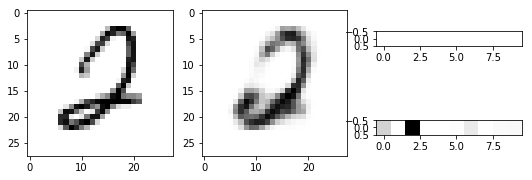

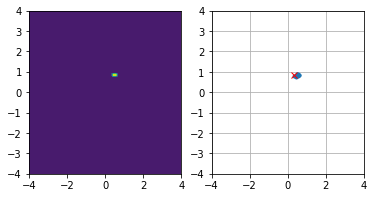

In [162]:
TEST_ZERO_x = 1
TEST_ZERO_y = 0
i = 10

#x_hat, y_hat = tf.nn.sigmoid((x_hat_logit, y_hat_logit)).eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
# = tf.nn.sigmoid().eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
x_hat_logit_test, y_hat_logit_test, mu_test, std_test, z_test = sess.run((x_hat_logit, y_hat_logit, mu_encoder, std_encoder, z), feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})
x_hat, y_hat = tf.nn.sigmoid(x_hat_logit_test), tf.nn.sigmoid(y_hat_logit_test)

plt.figure(figsize = (12,3))
plt.subplot(1,4,1)
plt.imshow(batch[0][i].reshape((28, 28)) * TEST_ZERO_x, cmap = 'gray_r')
plt.subplot(1,4,2)
plt.imshow(x_hat.eval()[i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(2,4,3)
plt.imshow(batch[1][i].reshape((1, 10)) * TEST_ZERO_y, cmap = 'gray_r')
plt.subplot(2,4,7)
plt.imshow(y_hat[i].eval().reshape((1, 10)) , cmap = 'gray_r')


print('categ = ', np.where(batch[1][i] == 1)[0][0])
#mu_test = mu_encoder.eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})[i]
print('mu = ', mu_test[i])
#std_test = std_encoder.eval(feed_dict={x: batch[0] * TEST_ZERO_x, y:batch[1]* TEST_ZERO_y})[i]
print('std = ', std_test[i])

DIM1 = 3
DIM2 = 4
axe_x, axe_y = np.mgrid[-4:4:.01, -4:4:.01]
q = multivariate_normal(mu_test[i], std_test[i]**2 * np.eye(params.latent_dim))
pos = np.empty(axe_x.shape + (params.latent_dim,))
pos[:, :, DIM1] = axe_x; pos[:, :, DIM2] = axe_y

plt.figure(figsize = (6, 3))
plt.subplot(1,2,1)
plt.contourf(axe_x, axe_y, q.pdf(pos))
ax = plt.subplot(1,2,2)
spl = q.rvs(10)
plt.plot(spl[:,DIM1], spl[:,DIM2], '.')
plt.plot(z_test[i,DIM1], z_test[i,DIM2], 'xr')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

In [ ]:
hidden_y_encoder.eval(feed_dict = {y : batch[1]})[i]

In [29]:
KLD_test, BCE_x_test, BCE_y_test = sess.run((KLD, BCE_x, BCE_y), feed_dict={x: batch[0] , y:batch[1]})


In [30]:
BCE_x_test

9711.5742

In [31]:
BCE_y_test

19.166883

In [32]:
KLD_test

2144.3965